In [2]:
import pandas as pd
from sklearn import svm
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
#from sklearn.neighbors.nca import NeighborhoodComponentsAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

from sklearn import model_selection
from sklearn.model_selection import KFold
import xgboost as xgb
import random
# from imblearn.over_sampling import SMOTE
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from time import time
from sklearn import manifold
from matplotlib.ticker import NullFormatter
import operator, itertools 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Harsh: Use Python[pytorch] kernel <others, please ignore this line>

In [3]:
# ### Considering on dummy data 
# # Input data : 
# # X = num_edges x num_methods, 
# # y = predictions (I - 0/1 values; II - 0/1/2/3 hop connections)

# E = 10000 # number of edges
# M = 6 # number of methods
# X = np.random.rand(E, M)
# y = np.random.choice([0, 1], size=E, p=[.9, .1]) # percentage labels

### Loading the data

In [4]:
df = pd.read_csv('data/yeast-edge-weights-v2.csv', sep=',')

In [5]:
df

,edge,prediction,pcc,clr,aracne,grnboost,mrnet,tinge
0,YGL035C-YGL209W,1,0.751521,11.994105,0.523881,90.332360,0.399111,0.525972
1,YGL035C-YPL177C,0,-0.026356,-0.301131,0.000242,0.000000,0.000000,0.006223
2,YGL035C-YML099C,0,-0.008957,-0.318885,0.000008,0.000000,0.000000,0.004775
3,YGL035C-YKR034W,0,0.014003,-0.200016,0.000008,0.000000,0.000000,0.005317
4,YGL035C-YIL119C,0,-0.109493,0.453919,0.007108,0.358562,0.001972,0.016401
5,YGL035C-YHR092C,1,-0.365564,5.943508,0.121728,36.166170,0.027365,0.138690
6,YGL035C-YPL111W,0,-0.005069,-0.510351,0.000450,0.000000,0.000000,0.004458
7,YGL035C-YIR029W,0,-0.328327,2.141256,0.063391,0.000000,0.004767,0.080994
8,YGL035C-YJL088W,0,-0.000030,-0.398242,0.000002,0.000000,0.000000,0.003356
9,YGL035C-YLR048W,0,0.058214,-0.441790,0.000338,0.000000,0.000373,0.005448


In [6]:
# for c in df.columns:
#     print(c, df[c].value_counts())
df['prediction'].value_counts()

0    1993804
1       5196
Name: prediction, dtype: int64

In [7]:
allOnes = df[df['prediction']==1]
allZeros = df[df['prediction']==0]
numOnes = len(allOnes)
numZeros = len(allZeros)
trainPTS = 20000 # train + valid
testPTS = 200000 # test
# choose 20K points for training
# Randomly choose 200K points for testing
# evenly divide the ones among train/test
df_train = pd.concat([allOnes[:numOnes//2], allZeros[:trainPTS]], ignore_index=True)
df_test = pd.concat([allOnes[numOnes//2:], allZeros[trainPTS: trainPTS+testPTS]], ignore_index=True)

## Visualizing the data
Sometimes it can be helpful, so why not!

In [24]:
def visual2D(X, color):
    Axes3D
    n_points = len(color)
    S = 30 # point size for figures

    n_neighbors = 10
    n_components = 2

    # fig = plt.figure(figsize=(15, 8))
    fig = plt.figure(figsize=(20, 8))
    plt.suptitle("2D projection with %i points, %i neighbors"
                 % (n_points, n_neighbors), fontsize=14)

    methods = ['standard', 'ltsa', 'hessian', 'modified']
    labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

    for i, method in enumerate(methods):
        t0 = time()
        Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                            eigen_solver='dense',
                                            method=method).fit_transform(X)
        t1 = time()
        print("%s: %.2g sec" % (methods[i], t1 - t0))

        ax = fig.add_subplot(252 + i)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
        plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

    t0 = time()
    Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
    t1 = time()
    print("Isomap: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(257)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("Isomap (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    mds = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = mds.fit_transform(X)
    t1 = time()
    print("MDS: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(258)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("MDS (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    t0 = time()
    se = manifold.SpectralEmbedding(n_components=n_components,
                                    n_neighbors=n_neighbors)
    Y = se.fit_transform(X)
    t1 = time()
    print("SpectralEmbedding: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(259)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=5)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(2, 5, 10)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral, s=S)
    plt.title("t-SNE (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    plt.show()

standard: 0.34 sec
ltsa: 0.44 sec
hessian: 0.64 sec
modified: 0.53 sec
Isomap: 0.97 sec
MDS: 5.7 sec
SpectralEmbedding: 0.22 sec
t-SNE: 24 sec


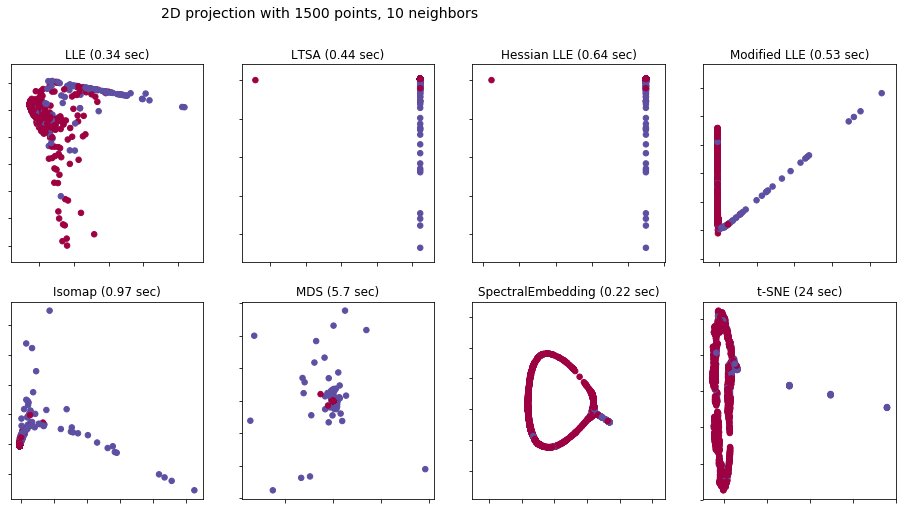

In [25]:
# Visualize the train data: 1500 points
colFeats = [c for c in df_train.columns if c not in ['prediction', 'edge']]

Xviz = np.array(df_train[colFeats])
yviz = np.array(df_train['prediction'])
vizPTS = np.random.choice(len(Xviz), 1500)
#print(Xviz[:vizPTS, :].shape, len(yviz[:vizPTS]), sum(yviz[:vizPTS]))
visual2D(Xviz[vizPTS, :], yviz[vizPTS])

## Binary Classification using traditional ML techniques - XGBoost

In [47]:
clf_VERSION = 'v1'
K = 5 # 5 fold cv

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.array(cm)
        cm = np.around(cm/cm.sum(axis=1)[:, None]*100).astype('int')
        print("Percentage confusion matrix")
        print(cm.sum(axis=1))
    else:
        print('Confusion matrix, without normalization')

#    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def show_confusion_matrix(y, pred_array):
    y = np.array(y).astype(int)
    y_pred = np.array(pred_array)

    cnf_matrix = confusion_matrix(y, y_pred)
    np.set_printoptions(precision=2)
    sorted_cnf_matrix = cnf_matrix
    class_names = ['yes', 'no'] #[0, 1]

    plot_confusion_matrix(sorted_cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
    plt.show()
    return


def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def get_auc_plot(y, scores):
    y = np.array(y).astype(int)
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
#    print(fpr, tpr, thresholds)
    # Getting accuracy, sensitivity and accuracy plot for varying thresholds. 
    accuracy_array = []
    sensitivity_array = [x*100 for x in tpr]
    specificity_array = [(1-x)*100 for x in fpr]#(1-fpr)*100
    for i, th in enumerate(thresholds):
        pred_array = []
        for s in scores:
            if s>th:
                pred_array.append(1)
            else:
                pred_array.append(0)
        accuracy_array.append(accuracy_score(y, pred_array))
#         print('For threshold : ', th, '->', ' Accuracy ', accuracy_array[i], 
#               ' Sensitivity ', sensitivity_array[i], 'specificity ', specificity_array[i])
#         show_confusion_matrix(y, pred_array)
#     print('accuracy_array', accuracy_array)
#     print('sensitivity_array', sensitivity_array)
#     print('specificity_array', specificity_array)
#     print('thresholds_array', thresholds)
    
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    for i in range(len(fpr)):
        if fpr[i] > 0.01:
            break
    return roc_auc, tpr[i], fpr[i]

def get_auc(y, scores):
    y = np.array(y).astype(int)
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    roc_auc = metrics.auc(fpr, tpr)

#     for i in range(len(fpr)):
#         if fpr[i] > 0.01:
#             break
    return roc_auc#, tpr[i], fpr[i]


def trainXGB(Xtrain, ytrain, Xtest, ytest):
    dtrain = xgb.DMatrix(Xtrain,label=ytrain)
    dtest = xgb.DMatrix(Xtest,label=ytest)
    print('Setting XGB params')
    evallist  = [(dtest,'test'), (dtrain,'train')]
    
    param = {}
    # use softmax multi-class classification
#    param['objective'] = 'multi:softprob'#'multi:softmax'
    param['objective'] = 'binary:logistic' #'multi:softprob'
    # scale weight of positive examples
    param['eta'] = 0.05
    param['max_depth'] = 5
    param['gamma'] = 0
    param['silent'] = 1
    param['nthread'] = 6
    param['subsample'] = 0.5#0.7 # number of examples for 1 tree (subsampled from total)
    param['colsample_bytree'] = 0.5#0.7 # ratio of columns for training 1 tree
#    param['num_class'] = NUM_CLASS
    param['eval_metric'] = 'auc'#'mlogloss' #auc

    # CLASS Imbalance handling!
    param['scale_pos_weight'] = 10#190/10 # sum(negative cases) / sum(positive cases)
    
#    param['booster'] = 'dart' #'gblinear' # default is tree booster
#    param['lambda'] = 1
#    param['alpha'] = 1

    num_round = 220#60
    print('training the XGB classifier')
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=100, verbose_eval=False)
    #print('training completed, printing the relative importance: \
    #      (feature id: importance value)')
    importance = bst.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    #print(importance)
    
    # we will print from df1 dataframe, getting the corresponding feature names. 
    df1 = pd.DataFrame(importance, columns=['feature', 'fscore'])
    # Normalizing the feature scores
    df1['fscore'] = df1['fscore'] / df1['fscore'].sum()
    
    #print(df1)
    # adding a column of feature name
    colFeats = [c for c in df_train.columns if c not in ['prediction', 'edge']]
    # column_names = df_train.columns[:-1]
    df1['feature_names'] = pd.Series([colFeats[int(f[0].replace("f", ""))] for f in importance])
    
    df1.plot()
    df1.plot(kind='barh', x='feature_names', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    plt.gcf().savefig('feature_importance_xgb.png')
    plt.show()
#    print 'Saving the models'
#    bst.save_model(name+'_xgb_v'+clf_VERSION+'.model')
#    bst.dump_model(name+'_xgb_v'+clf_VERSION+'_dump.raw.txt')
#    bst.dump_model(name+'_xgb_v'+clf_VERSION+'_dump.raw.txt',name+'_xgb_v'+clf_VERSION+'_featmap.txt')
    return bst


def classifier_train(X, y, runXGB, Xtest, ytest, pca_comp=0): # pca = 0 means no PCA applied
    print('Normalising the input data...')
    scaler = StandardScaler()
    scaler.fit(X)  
    scaledX = scaler.transform(X)
    if pca_comp != 0:
        pca = PCA(n_components = pca_comp)
        pca.fit(scaledX)
        pca_scaledX = pca.transform(scaledX)
    else:
        pca_scaledX = scaledX
        pca =0

    if runXGB == 1:
        print('Running the XGB classifier')
        clf = trainXGB(pca_scaledX, y, scaler.transform(Xtest), ytest)
        index = 1
    return scaler, pca, clf, index


def classifier_test(X, y, clf, index, scaler, pca):
    scaledX = scaler.transform(X)
    pca_scaledX = scaledX
    if pca != 0:
        pca_scaledX = pca.transform(scaledX)
    if index==1:# XGB
        pca_scaledXG = xgb.DMatrix(pca_scaledX, label=y)
        pred_array = clf.predict(pca_scaledXG, ntree_limit=clf.best_iteration)
        #.reshape(y.shape[0], NUM_CLASS)#, ntree_limit=clf.best_iteration)
        scores = pred_array

#    auc = get_auc(y, scores)

    auc = get_auc_plot(y, scores)
    # Compute confusion matrix
#    show_confusion_matrix(y, pred_array)
    return pred_array, auc# error


def individual_method(data):
    methods = [c for c in data.columns if c not in ['prediction', 'edge']]
    results = {}
    for m in methods:
        auc = get_auc(data['prediction'], data[m])
        results[m] = auc
    print(results)
    return
        
def pandas_classifier(df_train, df_test, runXGB, K=5):
    print('Performing ' + str(K) + '-fold cross validation')
    auc_fold = []
    colFeats = [c for c in df_train.columns if c not in ['prediction', 'edge']]
    print(colFeats)
  
    for k in range(K):# performing K fold validation
        #if k == 0: # running only for k'th fold
            print('Fold_num = ' + str(k))
            #train_rows = [i for i in range(len(df_train)) if i%K!=k]
            datatrain = df_train.loc[[i for i in range(len(df_train)) if i%K!=k]] # training
            #valid_rows = [i for i in range(len(df_train)) if i%K==k]
            datavalid = df_train.loc[[i for i in range(len(df_train)) if i%K==k]] # taking every k'th example
#             Xtrain =  #.iloc[:, 0:-1]
#             ytrain =  #.iloc[:, -1]
#             Xvalid =  #.iloc[:, 0:-1]
#             yvalid = #.iloc[:, -1]
            print('--------------------------------------------------------------')
            print('Calling the classifier to train')
            scaler, pca, clf, index = classifier_train(datatrain[colFeats], datatrain['prediction'], 
                                                       runXGB, datavalid[colFeats], datavalid['prediction'])
            print('Analysing the test predictions for fold num ', k)
            pred_array, auc = classifier_test(datavalid[colFeats],
                                              datavalid['prediction'], clf, index, scaler, 0)
            auc_fold.append(auc[0])
            print('test auc = '+str(auc[0]) )
            individual_method(datavalid)
            print('------------------------------------------------------------')
    if K != 0:
        print('************************************************************************')
        print(auc_fold)#, sum(np.array(auc_fold))/int(K))
        print('Average '+str(K)+' fold CV result= ', str(sum(np.array(auc_fold))/int(K)))
        print('************************************************************************')
#     print('Training the classifier on complete train dataset to get IMP features')
#     scaler, pca, clf, index = classifier_train(df.iloc[:, 0:-1], df.iloc[:, -1],
#                                                runXGB, df.iloc[:, 0:-1], df.iloc[:, -1])
    pred_array, auc = classifier_test(df_test[colFeats], df_test['prediction'], clf, index, scaler, 0)
    print('TEST AUC on standalone data = ', auc[0])
    print('individual methods: ', individual_method(df_test))
    return

Performing 5-fold cross validation
['pcc', 'clr', 'aracne', 'grnboost', 'mrnet', 'tinge']
Fold_num = 0
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


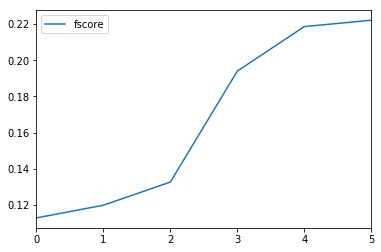

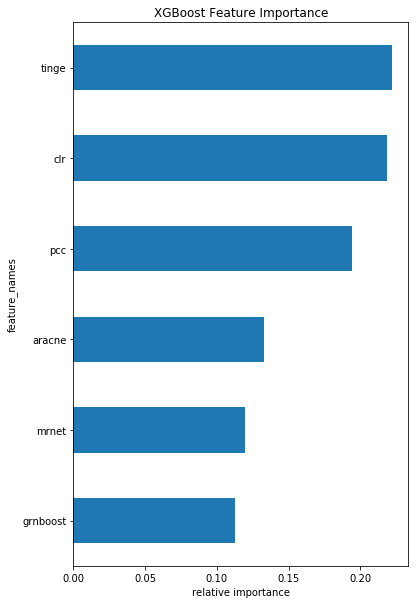

Analysing the test predictions for fold num  0


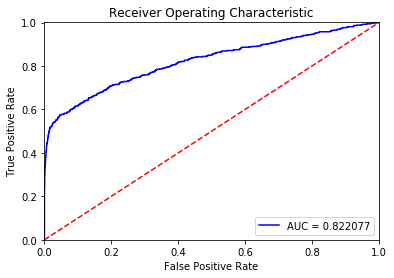

test auc = 0.8220766826923076
{'tinge': 0.7751024038461538, 'mrnet': 0.7674822115384615, 'clr': 0.7912524038461538, 'grnboost': 0.7817129807692308, 'aracne': 0.7670588942307692, 'pcc': 0.4642903846153846}
------------------------------------------------------------
Fold_num = 1
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


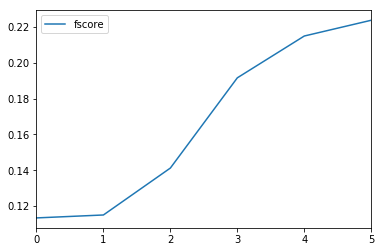

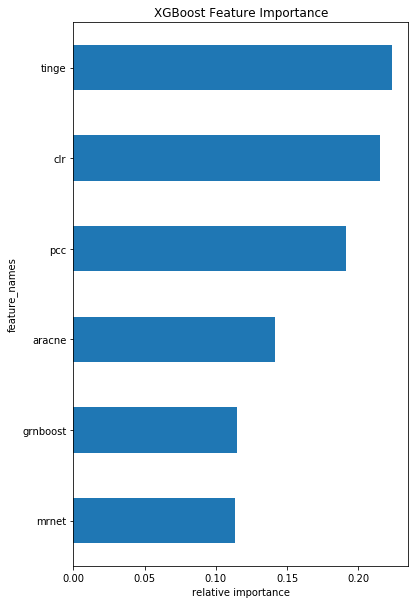

Analysing the test predictions for fold num  1


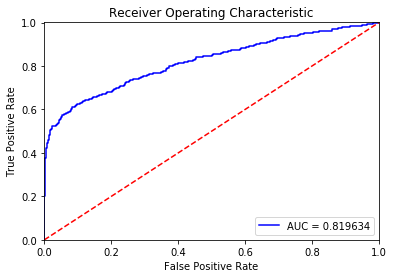

test auc = 0.8196336538461539
{'tinge': 0.755978846153846, 'mrnet': 0.7687504807692307, 'clr': 0.7883319711538462, 'grnboost': 0.7638485576923076, 'aracne': 0.765087019230769, 'pcc': 0.4977528846153846}
------------------------------------------------------------
Fold_num = 2
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


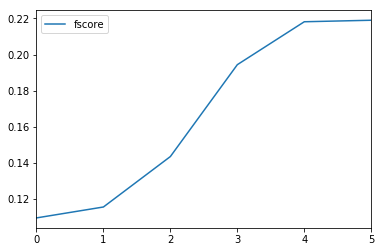

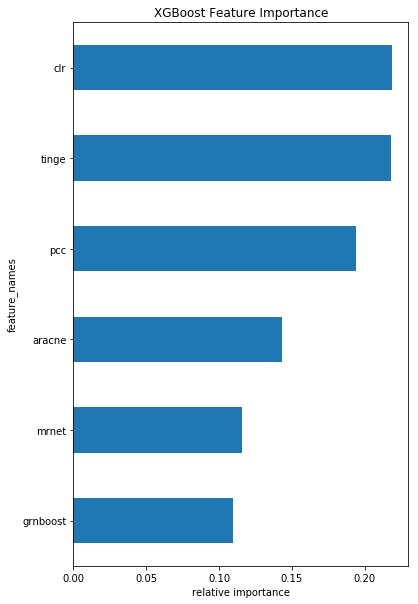

Analysing the test predictions for fold num  2


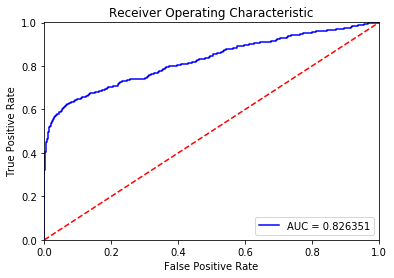

test auc = 0.8263514423076923
{'tinge': 0.7635901442307693, 'mrnet': 0.7713533653846154, 'clr': 0.7931699519230769, 'grnboost': 0.7817343749999999, 'aracne': 0.7495867788461539, 'pcc': 0.5110057692307692}
------------------------------------------------------------
Fold_num = 3
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


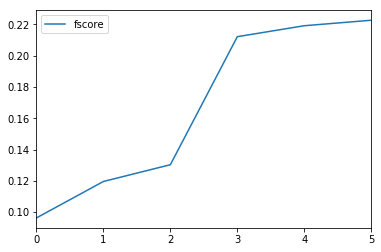

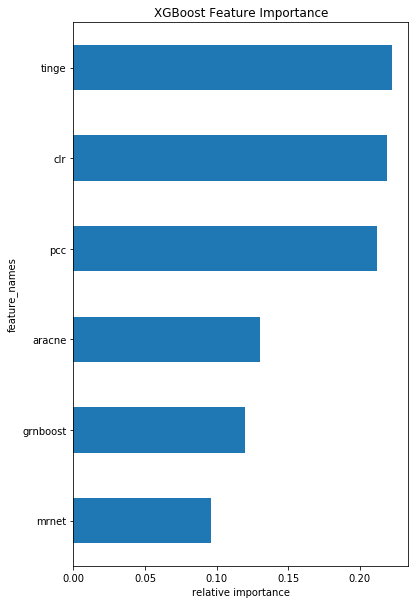

Analysing the test predictions for fold num  3


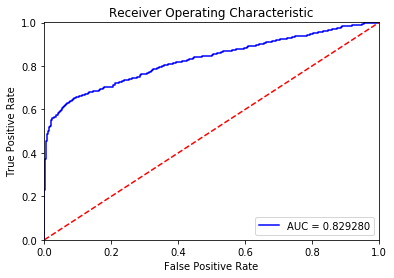

test auc = 0.8292798651252409
{'tinge': 0.7862685452793834, 'mrnet': 0.7961741329479768, 'clr': 0.8090997109826591, 'grnboost': 0.7866842485549134, 'aracne': 0.7719400289017341, 'pcc': 0.5060611753371869}
------------------------------------------------------------
Fold_num = 4
--------------------------------------------------------------
Calling the classifier to train
Normalising the input data...
Running the XGB classifier
Setting XGB params
training the XGB classifier


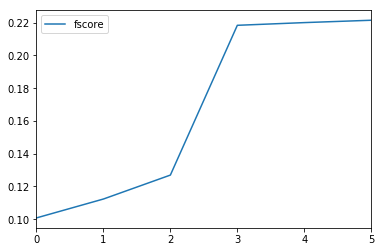

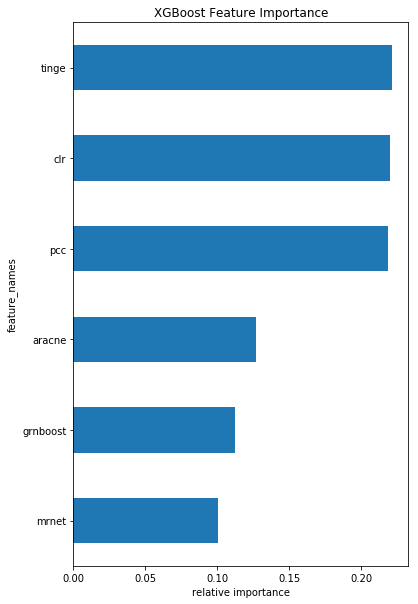

Analysing the test predictions for fold num  4


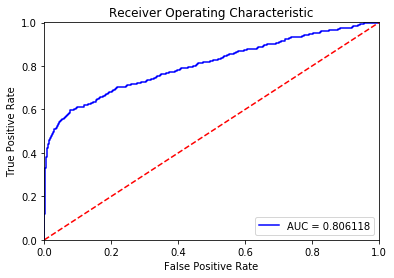

test auc = 0.8061180154142583
{'tinge': 0.7615953757225433, 'mrnet': 0.752426782273603, 'clr': 0.7894826589595376, 'grnboost': 0.7575582851637764, 'aracne': 0.7452938342967245, 'pcc': 0.4980558766859345}
------------------------------------------------------------
************************************************************************
[0.8220766826923076, 0.8196336538461539, 0.8263514423076923, 0.8292798651252409, 0.8061180154142583]
Average 5 fold CV result=  0.8206919318771305
************************************************************************


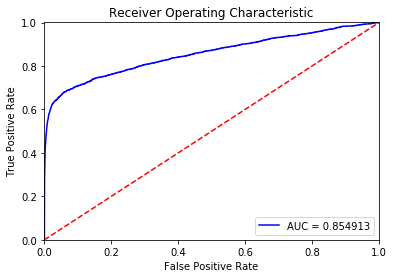

TEST AUC on standalone data =  0.8549128300615858


In [48]:
# Convert data to pandas before passing 
np.random.seed(15)
random.seed(15)
# df_X = pd.DataFrame(X, columns=[c for c in df.columns if c!='prediction'])
# df_y = pd.DataFrame(pd.Series(y, name='label'))
# df_train = pd.concat([df_X, df_y], axis=1)
# df_test

#print(df_classifier, df)
#print(df.columns)

pandas_classifier(df_train, df_test, 1)

In [49]:
print('individual methods: ', individual_method(df_test))

{'tinge': 0.8359971218244804, 'mrnet': 0.8312013433410317, 'clr': 0.8452145679368746, 'grnboost': 0.8162518851039262, 'aracne': 0.8183966887990762, 'pcc': 0.4936486951501155}
individual methods:  None
